In [12]:
import torch
import ipykernel
import pickle
import os

import import_ipynb
from typing import List, Tuple, Dict
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, Tensor

import warnings
from typing import Optional, Tuple
from torch.nn.modules.linear import Linear
from torch.nn.init import xavier_uniform_
from torch.nn.init import constant_
from torch.nn.init import xavier_normal_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

from torchvision.transforms import ToTensor, Normalize, Compose, Resize, RandomHorizontalFlip,RandomResizedCrop
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection

import matplotlib.pyplot as plt
import torch.optim as optim
import math

from torch._C import _infer_size, _add_docstr
from torch.nn import _reduction as _Reduction
from torch.nn.modules import utils
from torch.nn.modules.utils import _single, _pair, _triple, _list_with_default
from torch.nn import grad
from torch import _VF
from torch._jit_internal import boolean_dispatch, List, Optional, Tuple, ignore, _overload
try:
    from torch.overrides import has_torch_function, handle_torch_function
except:
    from torch.overrides import has_torch_function, handle_torch_function
Tensor = torch.Tensor

from torch.nn.functional import linear,pad,relu,softmax,dropout   

## DETR Model

## Positional encoding

In [36]:
class SimpleDetr(nn.Module):
    
## positional embedding
    @staticmethod
    def position_embedding_sine(tensor_list, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        x = tensor_list.tensors
        print(f"x:{x}")
    
        mask = tensor_list.mask
        assert mask is not None
        not_mask = ~mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * (2 * math.pi)
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * (2 * math.pi)

        dim_t = torch.arange(num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = temperature ** (2 * (dim_t // 2) / num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos
    
    @staticmethod
    def position_embedding_learned(tensor_list, num_pos_feats=256):
        x = tensor_list.tensors
        h, w = x.shape[-2:]
        i = torch.arange(w, device=x.device)
        j = torch.arange(h, device=x.device)
        
        i = i.clamp(max=49)
        j = j.clamp(max=49)
        
        x_emb = nn.Embedding(50, num_pos_feats)(i)
        y_emb = nn.Embedding(50, num_pos_feats)(j)
        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim=-1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)
        return pos


    @staticmethod
    def build_position_encoding(args):
        N_steps = args['hidden_dim'] // 2
        if args['position_embedding'] in ('v2', 'sine'):
            position_embedding = SimpleDetr.position_embedding_sine
        elif args['position_embedding'] in ('v3', 'learned'):
            position_embedding =SimpleDetr.position_embedding_learned
        else:
            raise ValueError(f"not supported {args.position_embedding}")

        return position_embedding
    

def gen_sineembed_for_position(pos_tensor, d_model=256):
    # n_query, bs, _ = pos_tensor.size()
    # sineembed_tensor = torch.zeros(n_query, bs, 256)
    scale = 2 * math.pi
    dim_t = torch.arange(d_model // 2, dtype=torch.float32, device=pos_tensor.device)
    dim_t = 10000 ** (2 * (dim_t // 2) / (d_model // 2))
    
    x_embed = pos_tensor[:, :, 0] * scale
    y_embed = pos_tensor[:, :, 1] * scale
    
    pos_x = x_embed[:, :, None] / dim_t
    pos_y = y_embed[:, :, None] / dim_t
    pos_x = torch.stack((pos_x[:, :, 0::2].sin(), pos_x[:, :, 1::2].cos()), dim=3).flatten(2)
    pos_y = torch.stack((pos_y[:, :, 0::2].sin(), pos_y[:, :, 1::2].cos()), dim=3).flatten(2)
    if pos_tensor.size(-1) == 2:
        pos = torch.cat((pos_y, pos_x), dim=2)
    elif pos_tensor.size(-1) == 4:
        w_embed = pos_tensor[:, :, 2] * scale
        pos_w = w_embed[:, :, None] / dim_t
        pos_w = torch.stack((pos_w[:, :, 0::2].sin(), pos_w[:, :, 1::2].cos()), dim=3).flatten(2)

        h_embed = pos_tensor[:, :, 3] * scale
        pos_h = h_embed[:, :, None] / dim_t
        pos_h = torch.stack((pos_h[:, :, 0::2].sin(), pos_h[:, :, 1::2].cos()), dim=3).flatten(2)

        pos = torch.cat((pos_y, pos_x, pos_w, pos_h), dim=2)
    else:
        raise ValueError("Unknown pos_tensor shape(-1):{}".format(pos_tensor.size(-1)))
    return pos


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class TensorList:
    def __init__(self, tensors, mask):
        self.tensors = tensors
        self.mask = mask

# Assume images is your batch of images and masks is the corresponding batch of masks
images = torch.rand(4, 3, 512, 512)
masks = torch.randint(0, 2, (4, 512, 512), dtype=torch.bool)

        
tensor_list = TensorList(images, masks)

In [33]:
# Define arguments for positional encoding - specify the desired method
args_sine = {'position_embedding': 'sine', 'hidden_dim': 256}
args_learned = {'position_embedding': 'learned', 'hidden_dim': 256}

# Call build_position_encoding with the arguments for sine encoding
position_encoding_func_sine = SimpleDetr.build_position_encoding(args_sine)

# Call build_position_encoding with the arguments for learned encoding
position_encoding_func_learned = SimpleDetr.build_position_encoding(args_learned)

# Now, you can call the obtained functions with tensor_list as argument to get the positional encoding tensors
pos_sine = position_encoding_func_sine(tensor_list)
pos_learned = position_encoding_func_learned(tensor_list)


x:tensor([[[[3.8525e-01, 8.2676e-01, 6.4084e-01,  ..., 5.0056e-01,
           7.9129e-01, 7.2237e-01],
          [2.5047e-01, 6.0700e-01, 1.0760e-03,  ..., 5.3734e-01,
           8.0219e-01, 4.6287e-01],
          [3.7229e-01, 1.6861e-01, 2.9759e-01,  ..., 2.4798e-01,
           3.8462e-01, 2.6983e-01],
          ...,
          [7.2146e-01, 8.2295e-01, 5.6380e-01,  ..., 7.7074e-03,
           2.5482e-01, 1.5795e-01],
          [9.8781e-01, 5.0301e-01, 3.2814e-01,  ..., 9.9864e-01,
           5.9254e-01, 3.3669e-01],
          [5.1009e-02, 1.5197e-02, 9.4712e-01,  ..., 8.2593e-01,
           8.8134e-01, 6.1073e-01]],

         [[7.2419e-01, 9.2457e-01, 4.2645e-01,  ..., 3.7512e-01,
           6.3278e-01, 8.2056e-01],
          [2.2453e-01, 2.6096e-01, 6.8639e-01,  ..., 9.4891e-01,
           5.7445e-01, 3.7804e-01],
          [1.0825e-01, 3.1744e-01, 2.2765e-02,  ..., 4.7473e-01,
           3.0568e-01, 1.1607e-01],
          ...,
          [6.9810e-01, 8.3202e-01, 6.1174e-01,  ..., 2.71

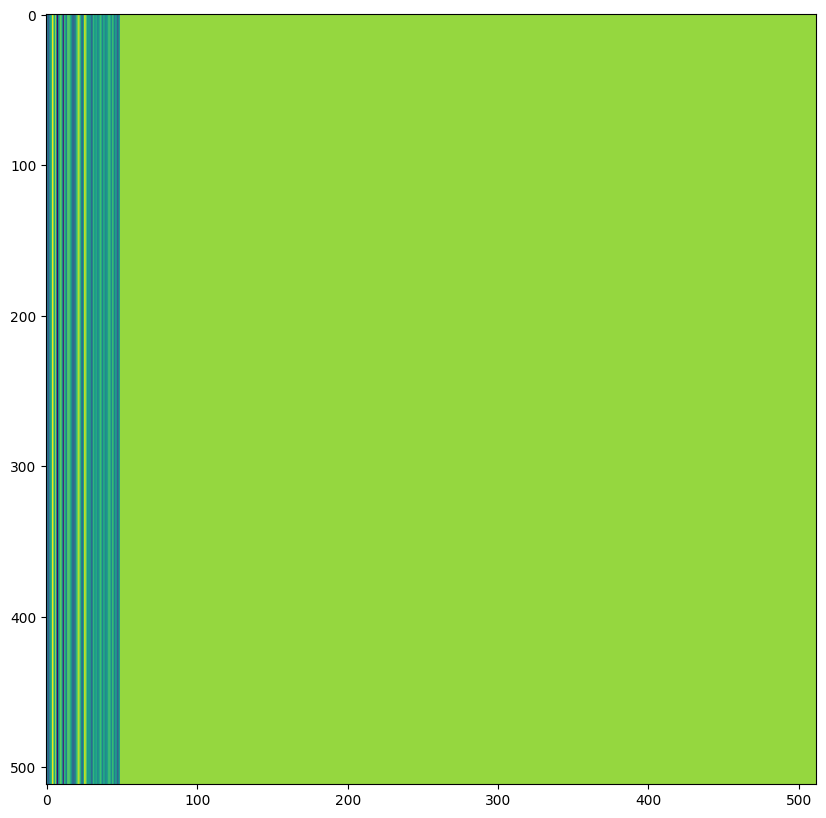

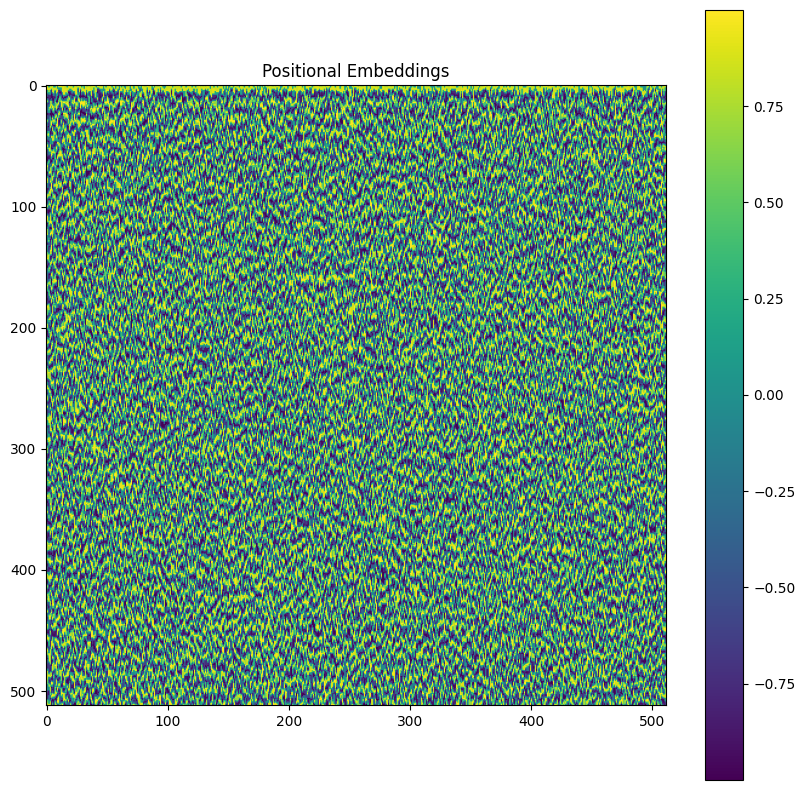

In [35]:
import matplotlib.pyplot as plt



# Convert tensor to numpy array
pos_np = pos_learned.detach().numpy()
os_np = pos_sine.detach().numpy()

# Plot the positional embeddings
plt.figure(figsize=(10,10))
plt.imshow(pos_np[0][0], cmap='viridis')

plt.figure(figsize=(10,10))
plt.imshow(os_np[0][0], cmap='viridis')

plt.colorbar()
plt.title('Positional Embeddings')
plt.show()

# InputEmbeddings

tensor([[[-18.7656,   5.4499,   1.3442,  ..., -30.5440,  -5.4096,  16.4352],
         [ -4.5086, -29.0936,   3.2893,  ..., -35.7406, -10.8095,  -2.7428],
         [-35.4751, -17.1265, -17.6715,  ..., -24.6692,  18.8854,   5.1831],
         ...,
         [ -6.5806,   5.2446,  27.3535,  ...,  20.0406,   2.3865, -20.3994],
         [-15.5295,  26.6877,   5.7768,  ...,  36.0142, -15.8686,  -8.4234],
         [  4.5509, -11.6658, -34.5228,  ...,   5.7238,  -7.5140,  11.2821]],

        [[ 25.8341, -26.3343, -31.4132,  ..., -31.0960,  -7.6242,  17.5082],
         [-11.5079,   4.4785,  33.4587,  ...,   5.9712,  11.8310,   8.5935],
         [  4.2997,  10.9930,   0.5519,  ..., -15.3182,  24.3972,  -6.5823],
         ...,
         [ 18.5643,  31.9285,   4.0406,  ...,  -6.3743,  24.2264, -25.9420],
         [-28.1902,  32.1644,  11.5143,  ...,  19.0098,  -7.4575,   5.8569],
         [-15.5295,  26.6877,   5.7768,  ...,  36.0142, -15.8686,  -8.4234]],

        [[ 15.2267, -15.3942, -13.1529,  ...

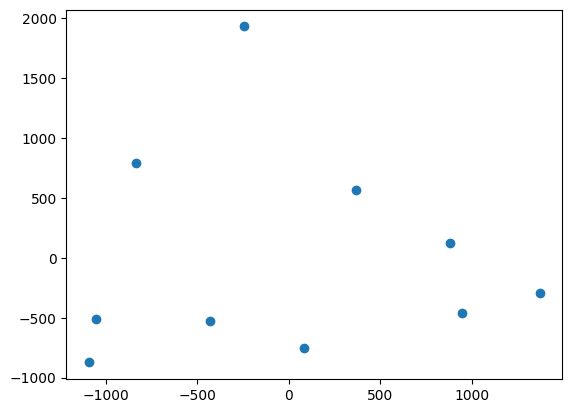

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, feature_dim: int) -> None: # d_model = 512 dimension of model, feature_dim = is the dimension of the input features for each bounding box 
        super().__init__()
        self.d_model = d_model
        self.feature_dim = feature_dim
        self.embedding = nn.Embedding(feature_dim, d_model)

    def forward(self, x):
        # (batch, feature_dim) --> (batch, feature_dim, d_model)
        # Multiply by sqrt(d_model) to scale the embeddings according to the paper
        return self.embedding(x) * math.sqrt(self.d_model)
    
    
    
# Create an instance of the class
input_embeddings = InputEmbeddings(d_model=512, feature_dim=100)

# Create some example input data
x = torch.randint(high=100, size=(10, 100))  # batch of 10 sequences, each sequence has 100 bounding boxes

# Pass the input data through the model
output = input_embeddings(x)

# Print the output
print(output)
print (output.shape)


# Flatten the output tensor and convert it to numpy
output_np = output.view(output.shape[0], -1).detach().numpy()

# Apply PCA
pca = PCA(n_components=2)
output_pca = pca.fit_transform(output_np)

# Plot the PCA-transformed embeddings
plt.scatter(output_pca[:, 0], output_pca[:, 1])
plt.show()

## FeedForwardBloc

In [ ]:
class MLP(nn.Module): # Multi Layer Perceptron (MLP) for the feedforward network

    def __init__(self, d_model: int, hidden_dim: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, hidden_dim) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_dim, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, hidden_dim) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

## MultiHeadAttentionBlock

In [2]:
class MultiheadAttention(Module):

    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None):
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        vdim = vdim if vdim is not None else embed_dim
        self.out_proj = Linear(vdim , vdim)

        self.in_proj_bias = None
        self.in_proj_weight = None
        self.bias_k = self.bias_v = None
        self.q_proj_weight = None
        self.k_proj_weight = None
        self.v_proj_weight = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        constant_(self.out_proj.bias, 0.)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super(MultiheadAttention, self).__setstate__(state)

    def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, attn_mask=None):
        # type: (Tensor, Tensor, Tensor, Optional[Tensor], bool, Optional[Tensor]) -> Tuple[Tensor, Optional[Tensor]]


        if not self._qkv_same_embed_dim:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight, out_dim=self.vdim)
        else:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, out_dim=self.vdim)


def multi_head_attention_forward(query: Tensor,
                                 key: Tensor,
                                 value: Tensor,
                                 embed_dim_to_check: int,
                                 num_heads: int,
                                 in_proj_weight: Tensor,
                                 in_proj_bias: Tensor,
                                 bias_k: Optional[Tensor],
                                 bias_v: Optional[Tensor],
                                 add_zero_attn: bool,
                                 dropout_p: float,
                                 out_proj_weight: Tensor,
                                 out_proj_bias: Tensor,
                                 training: bool = True,
                                 key_padding_mask: Optional[Tensor] = None,
                                 need_weights: bool = True,
                                 attn_mask: Optional[Tensor] = None,
                                 use_separate_proj_weight: bool = False,
                                 q_proj_weight: Optional[Tensor] = None,
                                 k_proj_weight: Optional[Tensor] = None,
                                 v_proj_weight: Optional[Tensor] = None,
                                 static_k: Optional[Tensor] = None,
                                 static_v: Optional[Tensor] = None,
                                 out_dim: Optional[Tensor] = None
                                 ) -> Tuple[Tensor, Optional[Tensor]]:
    
    
    if not torch.jit.is_scripting():
        tens_ops = (query, key, value, in_proj_weight, in_proj_bias, bias_k, bias_v,
                    out_proj_weight, out_proj_bias)
        if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
            return handle_torch_function(
                multi_head_attention_forward, tens_ops, query, key, value,
                embed_dim_to_check, num_heads, in_proj_weight, in_proj_bias,
                bias_k, bias_v, add_zero_attn, dropout_p, out_proj_weight,
                out_proj_bias, training=training, key_padding_mask=key_padding_mask,
                need_weights=need_weights, attn_mask=attn_mask,
                use_separate_proj_weight=use_separate_proj_weight,
                q_proj_weight=q_proj_weight, k_proj_weight=k_proj_weight,
                v_proj_weight=v_proj_weight, static_k=static_k, static_v=static_v)
    tgt_len, bsz, embed_dim = query.size()
    assert embed_dim == embed_dim_to_check
    # allow MHA to have different sizes for the feature dimension
    assert key.size(0) == value.size(0) and key.size(1) == value.size(1)

    head_dim = embed_dim // num_heads
    v_head_dim = out_dim // num_heads
    assert head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
    scaling = float(head_dim) ** -0.5

    q = query * scaling
    k = key
    v = value

    if attn_mask is not None:
        assert attn_mask.dtype == torch.float32 or attn_mask.dtype == torch.float64 or \
            attn_mask.dtype == torch.float16 or attn_mask.dtype == torch.uint8 or attn_mask.dtype == torch.bool, \
            'Only float, byte, and bool types are supported for attn_mask, not {}'.format(attn_mask.dtype)
        if attn_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            attn_mask = attn_mask.to(torch.bool)

        if attn_mask.dim() == 2:
            attn_mask = attn_mask.unsqueeze(0)
            if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                raise RuntimeError('The size of the 2D attn_mask is not correct.')
        elif attn_mask.dim() == 3:
            if list(attn_mask.size()) != [bsz * num_heads, query.size(0), key.size(0)]: # bsz is batch size
                raise RuntimeError('The size of the 3D attn_mask is not correct.')
        else:
            raise RuntimeError("attn_mask's dimension {} is not supported".format(attn_mask.dim()))
        # attn_mask's dim is 3 now.

    # convert ByteTensor key_padding_mask to bool
    if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
        warnings.warn("Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
        key_padding_mask = key_padding_mask.to(torch.bool)

    if bias_k is not None and bias_v is not None:
        if static_k is None and static_v is None:
            k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
            v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
            if attn_mask is not None:
                attn_mask = pad(attn_mask, (0, 1))
            if key_padding_mask is not None:
                key_padding_mask = pad(key_padding_mask, (0, 1))
        else:
            assert static_k is None, "bias cannot be added to static key."
            assert static_v is None, "bias cannot be added to static value."
    else:
        assert bias_k is None
        assert bias_v is None
        
# reshaping the input to be compatible with the linear projection
    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1) 
    if k is not None:
        k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)  # bsz is batch size
    if v is not None:
        v = v.contiguous().view(-1, bsz * num_heads, v_head_dim).transpose(0, 1)

    if static_k is not None:
        assert static_k.size(0) == bsz * num_heads
        assert static_k.size(2) == head_dim
        k = static_k

    if static_v is not None:
        assert static_v.size(0) == bsz * num_heads # bsz is batch size
        assert static_v.size(2) == v_head_dim
        v = static_v

    src_len = k.size(1)

    if key_padding_mask is not None:
        assert key_padding_mask.size(0) == bsz  # bsz is batch size
        assert key_padding_mask.size(1) == src_len

    if add_zero_attn:
        src_len += 1
        k = torch.cat([k, torch.zeros((k.size(0), 1) + k.size()[2:], dtype=k.dtype, device=k.device)], dim=1)
        v = torch.cat([v, torch.zeros((v.size(0), 1) + v.size()[2:], dtype=v.dtype, device=v.device)], dim=1)
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))

    attn_output_weights = torch.bmm(q, k.transpose(1, 2)) # batch matrix multiplication (torch.bmm) q and k
    assert list(attn_output_weights.size()) == [bsz * num_heads, tgt_len, src_len]

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_output_weights.masked_fill_(attn_mask, float('-inf'))
        else:
            attn_output_weights += attn_mask


    if key_padding_mask is not None:
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        attn_output_weights = attn_output_weights.masked_fill(
            key_padding_mask.unsqueeze(1).unsqueeze(2),
            float('-inf'),
        )
        attn_output_weights = attn_output_weights.view(bsz * num_heads, tgt_len, src_len)

    # attn_output_weights = softmax(
    #     attn_output_weights, dim=-1)
    attn_output_weights = softmax(
            attn_output_weights - attn_output_weights.max(dim=-1, keepdim=True)[0], dim=-1)
    attn_output_weights = dropout(attn_output_weights, p=dropout_p, training=training)

    attn_output = torch.bmm(attn_output_weights, v) # batch matrix multiplication (torch.bmm) with v
    assert list(attn_output.size()) == [bsz * num_heads, tgt_len, v_head_dim]
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, out_dim)
    attn_output = linear(attn_output, out_proj_weight, out_proj_bias)

    if need_weights:
        # average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        return attn_output, attn_output_weights.sum(dim=1) / num_heads
    else:
        return attn_output, None

## Neccesary Functions

In [ ]:
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def inverse_sigmoid(x, eps=1e-3):
    x = x.clamp(min=0, max=1)
    x1 = x.clamp(min=eps)
    x2 = (1 - x).clamp(min=eps)
    return torch.log(x1/x2)

def _get_activation_fn(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return F.relu
    if activation == "gelu":
        return F.gelu
    if activation == "glu":
        return F.glu
    if activation == "prelu":
        return nn.PReLU()
    if activation == "selu":
        return F.selu
    raise RuntimeError(F"activation should be relu/gelu, not {activation}.")


## EncoderBlock

In [ ]:
class TransformerEncoder(nn.Module):

    def __init__(self, encoder_layer, num_layers, norm=None, d_model=256):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.query_scale = MLP(d_model, d_model, d_model, 2)
        self.norm = norm

    def forward(self, src,
                mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        output = src

        for layer_id, layer in enumerate(self.layers):
            # rescale the content and pos sim
            pos_scales = self.query_scale(output)
            output = layer(output, src_mask=mask,
                           src_key_padding_mask=src_key_padding_mask, pos=pos*pos_scales)

        if self.norm is not None:
            output = self.norm(output)

        return output
    


## Encoder

In [ ]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward(self,
                     src,
                     src_mask: Optional[Tensor] = None,
                     src_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None):
        q = k = self.with_pos_embed(src, pos)
        src2 = self.self_attn(q, k, value=src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

## DecoderBlock

In [ ]:
class TransformerDecoder(nn.Module):

    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False, 
                    d_model=256, query_dim=2, keep_query_pos=False, query_scale_type='cond_elewise',
                    modulate_hw_attn=False,
                    bbox_embed_diff_each_layer=False,
                    ):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate
        assert return_intermediate
        self.query_dim = query_dim

        assert query_scale_type in ['cond_elewise', 'cond_scalar', 'fix_elewise']
        self.query_scale_type = query_scale_type
        if query_scale_type == 'cond_elewise':
            self.query_scale = MLP(d_model, d_model, d_model, 2)
        elif query_scale_type == 'cond_scalar':
            self.query_scale = MLP(d_model, d_model, 1, 2)
        elif query_scale_type == 'fix_elewise':
            self.query_scale = nn.Embedding(num_layers, d_model)
        else:
            raise NotImplementedError("Unknown query_scale_type: {}".format(query_scale_type))
        
        self.ref_point_head = MLP(query_dim // 2 * d_model, d_model, d_model, 2)
        
        self.bbox_embed = None
        self.d_model = d_model
        self.modulate_hw_attn = modulate_hw_attn
        self.bbox_embed_diff_each_layer = bbox_embed_diff_each_layer


        if modulate_hw_attn:
            self.ref_anchor_head = MLP(d_model, d_model, 2, 2)

        
        if not keep_query_pos:
            for layer_id in range(num_layers - 1):
                self.layers[layer_id + 1].ca_qpos_proj = None

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                refpoints_unsigmoid: Optional[Tensor] = None, # num_queries, bs, 2
                ):
        output = tgt

        intermediate = []
        reference_points = refpoints_unsigmoid.sigmoid()
        ref_points = [reference_points]

        # import ipdb; ipdb.set_trace()        

        for layer_id, layer in enumerate(self.layers):
            obj_center = reference_points[..., :self.query_dim]     # [num_queries, batch_size, 2]
            # get sine embedding for the query vector
            query_sine_embed = gen_sineembed_for_position(obj_center, self.d_model)  
            query_pos = self.ref_point_head(query_sine_embed) 

            # For the first decoder layer, we do not apply transformation over p_s
            if self.query_scale_type != 'fix_elewise':
                if layer_id == 0:
                    pos_transformation = 1
                else:
                    pos_transformation = self.query_scale(output)
            else:
                pos_transformation = self.query_scale.weight[layer_id]

            # apply transformation
            query_sine_embed = query_sine_embed[...,:self.d_model] * pos_transformation

            # modulated HW attentions
            if self.modulate_hw_attn:
                refHW_cond = self.ref_anchor_head(output).sigmoid() # nq, bs, 2
                query_sine_embed[..., self.d_model // 2:] *= (refHW_cond[..., 0] / obj_center[..., 2]).unsqueeze(-1)
                query_sine_embed[..., :self.d_model // 2] *= (refHW_cond[..., 1] / obj_center[..., 3]).unsqueeze(-1)


            output = layer(output, memory, tgt_mask=tgt_mask,
                           memory_mask=memory_mask,
                           tgt_key_padding_mask=tgt_key_padding_mask,
                           memory_key_padding_mask=memory_key_padding_mask,
                           pos=pos, query_pos=query_pos, query_sine_embed=query_sine_embed,
                           is_first=(layer_id == 0))

            # iter update
            if self.bbox_embed is not None:
                if self.bbox_embed_diff_each_layer:
                    tmp = self.bbox_embed[layer_id](output)
                else:
                    tmp = self.bbox_embed(output)
                # import ipdb; ipdb.set_trace()
                tmp[..., :self.query_dim] += inverse_sigmoid(reference_points)
                new_reference_points = tmp[..., :self.query_dim].sigmoid()
                if layer_id != self.num_layers - 1:
                    ref_points.append(new_reference_points)
                reference_points = new_reference_points.detach()

            if self.return_intermediate:
                intermediate.append(self.norm(output))

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)

        if self.return_intermediate:
            if self.bbox_embed is not None:
                return [
                    torch.stack(intermediate).transpose(1, 2),
                    torch.stack(ref_points).transpose(1, 2),
                ]
            else:
                return [
                    torch.stack(intermediate).transpose(1, 2), 
                    reference_points.unsqueeze(0).transpose(1, 2)
                ]

        return output.unsqueeze(0)


## Decoder

In [ ]:
class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False, keep_query_pos=False,
                 rm_self_attn_decoder=False):
        super().__init__()
        # Decoder Self-Attention
        if not rm_self_attn_decoder:
            self.sa_qcontent_proj = nn.Linear(d_model, d_model)
            self.sa_qpos_proj = nn.Linear(d_model, d_model)
            self.sa_kcontent_proj = nn.Linear(d_model, d_model)
            self.sa_kpos_proj = nn.Linear(d_model, d_model)
            self.sa_v_proj = nn.Linear(d_model, d_model)
            self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout, vdim=d_model)

            self.norm1 = nn.LayerNorm(d_model)
            self.dropout1 = nn.Dropout(dropout)

        # Decoder Cross-Attention
        self.ca_qcontent_proj = nn.Linear(d_model, d_model)
        self.ca_qpos_proj = nn.Linear(d_model, d_model)
        self.ca_kcontent_proj = nn.Linear(d_model, d_model)
        self.ca_kpos_proj = nn.Linear(d_model, d_model)
        self.ca_v_proj = nn.Linear(d_model, d_model)
        self.ca_qpos_sine_proj = nn.Linear(d_model, d_model)
        self.cross_attn = MultiheadAttention(d_model*2, nhead, dropout=dropout, vdim=d_model)

        self.nhead = nhead
        self.rm_self_attn_decoder = rm_self_attn_decoder

        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before
        self.keep_query_pos = keep_query_pos

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward(self, tgt, memory,
                     tgt_mask: Optional[Tensor] = None,
                     memory_mask: Optional[Tensor] = None,
                     tgt_key_padding_mask: Optional[Tensor] = None,
                     memory_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None,
                     query_pos: Optional[Tensor] = None,
                     query_sine_embed = None,
                     is_first = False):
                     
        # ========== Begin of Self-Attention =============
        if not self.rm_self_attn_decoder:
            # Apply projections here
            # shape: num_queries x batch_size x 256
            q_content = self.sa_qcontent_proj(tgt)      # target is the input of the first decoder layer. zero by default.
            q_pos = self.sa_qpos_proj(query_pos)
            k_content = self.sa_kcontent_proj(tgt)
            k_pos = self.sa_kpos_proj(query_pos)
            v = self.sa_v_proj(tgt)

            num_queries, bs, n_model = q_content.shape
            hw, _, _ = k_content.shape

            q = q_content + q_pos
            k = k_content + k_pos

            tgt2 = self.self_attn(q, k, value=v, attn_mask=tgt_mask,
                                key_padding_mask=tgt_key_padding_mask)[0]
            # ========== End of Self-Attention =============

            tgt = tgt + self.dropout1(tgt2)
            tgt = self.norm1(tgt)

        # ========== Begin of Cross-Attention =============
        # Apply projections here
        # shape: num_queries x batch_size x 256
        q_content = self.ca_qcontent_proj(tgt)
        k_content = self.ca_kcontent_proj(memory)
        v = self.ca_v_proj(memory)

        num_queries, bs, n_model = q_content.shape
        hw, _, _ = k_content.shape

        k_pos = self.ca_kpos_proj(pos)

        # For the first decoder layer, we concatenate the positional embedding predicted from 
        # the object query (the positional embedding) into the original query (key) in DETR.
        if is_first or self.keep_query_pos:
            q_pos = self.ca_qpos_proj(query_pos)
            q = q_content + q_pos
            k = k_content + k_pos
        else:
            q = q_content
            k = k_content

        q = q.view(num_queries, bs, self.nhead, n_model//self.nhead)
        query_sine_embed = self.ca_qpos_sine_proj(query_sine_embed)
        query_sine_embed = query_sine_embed.view(num_queries, bs, self.nhead, n_model//self.nhead)
        q = torch.cat([q, query_sine_embed], dim=3).view(num_queries, bs, n_model * 2)
        k = k.view(hw, bs, self.nhead, n_model//self.nhead)
        k_pos = k_pos.view(hw, bs, self.nhead, n_model//self.nhead)
        k = torch.cat([k, k_pos], dim=3).view(hw, bs, n_model * 2)

        tgt2 = self.cross_attn(query=q,
                                   key=k,
                                   value=v, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]               
        # ========== End of Cross-Attention =============

        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

## ProjectionLayer needs to be edited to included

In [ ]:
#class ProjectionLayer(nn.Module):

    #def __init__(self, d_model, vocab_size) -> None:
        #super().__init__()
        #self.proj = nn.Linear(d_model, vocab_size)

    #def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        #return self.proj(x)
    
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, num_classes, box_dim) -> None: # d_model = 256, num_classes = 91, box_dim = 4
        super().__init__()
        self.class_proj = nn.Linear(d_model, num_classes)
        self.box_proj = nn.Linear(d_model, box_dim)

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, num_classes)
        class_logits = self.class_proj(x)
        # (batch, seq_len, d_model) --> (batch, seq_len, box_dim)
        box_regression = self.box_proj(x)
        return class_logits, box_regression

## Transformer Block

In [ ]:
class Transformer(nn.Module):

    def __init__(self, d_model=512, nhead=8, num_queries=300, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False,
                 return_intermediate_dec=False, query_dim=4,
                 keep_query_pos=False, query_scale_type='cond_elewise',
                 num_patterns=0,
                 modulate_hw_attn=True,
                 bbox_embed_diff_each_layer=False,
                 ):

        super().__init__()

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before)
        encoder_norm = nn.LayerNorm(d_model) if normalize_before else None
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before, keep_query_pos=keep_query_pos)
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm,
                                          return_intermediate=return_intermediate_dec,
                                          d_model=d_model, query_dim=query_dim, keep_query_pos=keep_query_pos, query_scale_type=query_scale_type,
                                          modulate_hw_attn=modulate_hw_attn,
                                          bbox_embed_diff_each_layer=bbox_embed_diff_each_layer)

        self._reset_parameters()
        assert query_scale_type in ['cond_elewise', 'cond_scalar', 'fix_elewise']

        self.d_model = d_model
        self.nhead = nhead
        self.dec_layers = num_decoder_layers
        self.num_queries = num_queries
        self.num_patterns = num_patterns
        if not isinstance(num_patterns, int):
            Warning("num_patterns should be int but {}".format(type(num_patterns)))
            self.num_patterns = 0
        if self.num_patterns > 0:
            self.patterns = nn.Embedding(self.num_patterns, d_model)

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, mask, refpoint_embed, pos_embed):
        # flatten NxCxHxW to HWxNxC
        bs, c, h, w = src.shape
        src = src.flatten(2).permute(2, 0, 1)
        pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
        refpoint_embed = refpoint_embed.unsqueeze(1).repeat(1, bs, 1)
        mask = mask.flatten(1)        
        memory = self.encoder(src, src_key_padding_mask=mask, pos=pos_embed)

        # query_embed = gen_sineembed_for_position(refpoint_embed)
        num_queries = refpoint_embed.shape[0]
        if self.num_patterns == 0:
            tgt = torch.zeros(num_queries, bs, self.d_model, device=refpoint_embed.device)
        else:
            tgt = self.patterns.weight[:, None, None, :].repeat(1, self.num_queries, bs, 1).flatten(0, 1) # n_q*n_pat, bs, d_model
            refpoint_embed = refpoint_embed.repeat(self.num_patterns, 1, 1) # n_q*n_pat, bs, d_model
            # import ipdb; ipdb.set_trace()
        hs, references = self.decoder(tgt, memory, memory_key_padding_mask=mask,
                          pos=pos_embed, refpoints_unsigmoid=refpoint_embed)
        return hs, references

## Transformer

In [ ]:

def build_transformer(args):
    return Transformer(
        d_model=args.hidden_dim,
        dropout=args.dropout,
        nhead=args.nheads,
        num_queries=args.num_queries,
        dim_feedforward=args.dim_feedforward,
        num_encoder_layers=args.enc_layers,
        num_decoder_layers=args.dec_layers,
        normalize_before=args.pre_norm,
        return_intermediate_dec=True,
        query_dim=4,
        activation=args.transformer_activation,
        num_patterns=args.num_patterns,
    )